In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
# import tensorflow.compat.v1 as tf1
from tensorflow.keras import activations
tf.compat.v1.disable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2022-11-30 01:55:49.175109: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from cust_rnn import BasicRNNCell

In [4]:
n_windows = 200
n_input =  1
n_output = 1
size_train = 2001
r_neuron = 120   

In [5]:
def create_ts(start = '2001', n = 201, freq = 'M'):
    rng = pd.date_range(start=start, periods=n, freq=freq)
    ts = pd.Series(np.random.uniform(-18, 18, size=len(rng)), rng).cumsum()
    return ts
# ts = create_ts(start = '2001', n = 2205))
# ts = create_ts(start = '2001', n = 2205)
ts = range(2205)

In [6]:
series = np.array(ts[3:])
train = series[:size_train]
test = series[size_train:]
print(train.shape, test.shape)

(2001,) (201,)


In [7]:
x_data = train[1:size_train]
y_data = train[:size_train-1]
X_batches = x_data.reshape(-1, n_windows, n_input)
y_batches = y_data.reshape(-1, n_windows, n_input)

In [8]:
params = {"l2scale":4e-6,
        "alpha_resample_ratio":0.2,
        "transition_std":[10,10,10],
        "time_step":1.0,
        "decayrate":0.5,
        "learningrate":0.0001,
        "num_particles":100,
        }

In [9]:
batch_num = 10
particle_states_inits = np.zeros((batch_num,params["num_particles"], 3)) 
for i in range(0,batch_num):
    ri = np.zeros((params["num_particles"], 3))
    # tsi = x_data[i*n_windows:i*n_windows + 3]
    # r = [tsi[2],  (tsi[2] - tsi[1]) / params['time_step'], ((tsi[2] - tsi[1]) - (tsi[1] - tsi[0])) / params['time_step']]

    #some cheating
    inc_data = x_data[i*n_windows:(i+1)*n_windows]
    v = [i-j for i,j in zip(inc_data[1:], inc_data[:-1])]
    a = [i-j for i,j in zip(v[1:], v[:-1])]
    r = [inc_data[0],  np.average(v), np.average(a)]
    for ridx in range(0,3):
        ri[:,ridx] = np.random.uniform(r[ridx] - params['transition_std'][ridx], r[ridx] + params['transition_std'][ridx], (params["num_particles"]))
    particle_states_inits[i] = ri


In [10]:
fv = np.log(1.0/float(params['num_particles']))
particle_weights_inits = np.full(shape=particle_states_inits.shape[:-1], fill_value=fv)

In [11]:
lag_len = 5
last_window_points = np.array([x_data[i-lag_len:i] if i>=lag_len else np.concatenate((np.zeros(lag_len-i),x_data[:i])) for i in range(0,len(x_data))]).reshape(batch_num, n_windows, -1)

In [12]:
from cust_rnn import PFNET

In [13]:
batches_to_include = 1
points_to_include = 30
fl = [X_batches[:batches_to_include,:points_to_include], particle_states_inits[:batches_to_include], particle_weights_inits[:batches_to_include], last_window_points[:batches_to_include,:points_to_include], y_batches[:batches_to_include, :points_to_include]]

In [14]:
[i.shape for i in fl]

[(1, 30, 1), (1, 100, 3), (1, 100), (1, 30, 5), (1, 30, 1)]

In [15]:
train_brain = PFNET(params, [fl[1].shape, fl[0].shape, fl[3].shape], fl[4].shape, True)

Instructions for updating:
Use `tf.random.categorical` instead.


2022-11-30 01:55:55.234778: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [16]:
init_op = tf.group(tf.compat.v1.global_variables_initializer(), tf.compat.v1.local_variables_initializer())
iteration = 10
with tf.compat.v1.Session() as sess:
    sess.run(init_op)
    print("done with run init") #11
    # obs_in, init_particle_states, init_particle_weights, prev_window, true_pos
    
    fd = {i:fl[idx] for idx, i in enumerate(train_brain.inputs)}
    print("done with fd") #0
    o_min = None
    o_max = None
    loss_min = 1000000000
    loss_max = 0
    for iters in range(iteration):
        _, loss,_, o= sess.run([train_brain.train_op, train_brain.train_loss_op, train_brain.update_state_op, train_brain.print_state_op], feed_dict=fd)
        if loss < loss_min:
            loss_min = loss
            o_min = o
        if loss > loss_max:
            loss_max = loss
            o_max = o
        print(loss)
    print(loss_min, loss_max)
    print("done with op") #4

2022-11-30 01:55:55.725661: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


done with run init
done with fd
2871537.2
8425042.0
5568849.0
816915.5
7066531.5
679861.2
3844052.8
62249.324
535272.7
10607002.0
62249.324 10607002.0
done with op


In [17]:
from ref_pf import ref_pf
import copy
rpf = ref_pf(params=params)
pos_func = lambda x: x[:,0] + (x[:,1] * params['time_step']) + (0.5 * x[:,2] * params['time_step']**2)

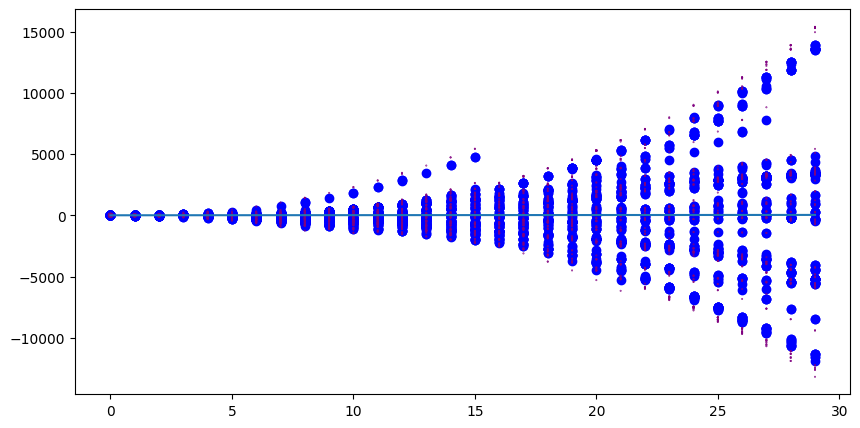

In [18]:
# iter_idx = 0
# test_states = o[0][0][iter_idx]
# test_weights = o[1][0][iter_idx]
# test_states.shape, test_weights.shape
batch_idx = 0
points_to_plot = 30
# for o in [o_min, o_max]:
pre_trans_states = o_min[0][batch_idx]
pre_trans_weights = o_min[1][batch_idx]
post_trans_states = o_min[2][batch_idx]
post_trans_weights = o_min[3][batch_idx]
fig, ax = plt.subplots(1,1, figsize = (10,5))
x = np.array([0]*len(particle_states_inits[0]))
# ax.scatter(x-0.1,particle_states_inits[0,:,0], c = 'b')
for idx in range(points_to_plot):
    ax.scatter(x+idx,pre_trans_states[idx][:,0], c = 'b')
    # ax.scatter(x+0.1,pos_func(particle_states_inits[0]), c = 'b')
    ax.scatter(x+idx,pos_func(pre_trans_states[idx]), c = 'purple', s = pre_trans_weights[idx]*1000)
    # ax.scatter(x+1,post_trans_states[:,0], c = 'b')
ax.plot(X_batches[batch_idx,:points_to_plot])
plt.show()

In [19]:
min_obs_likelihood = 0.04
x = (np.array([0,1,2,3,4,5,6,7,8,9]))/10
x * (1 - min_obs_likelihood) + min_obs_likelihood

array([0.04 , 0.136, 0.232, 0.328, 0.424, 0.52 , 0.616, 0.712, 0.808,
       0.904])

In [20]:
# test weights loved state sample 5, with value -8.568, velocity -14, acc -24
# i assume this sent all the weights into a massive downwards spiral

In [21]:
x_data_pf = fl[0][0]
init_part_pf = copy.deepcopy(fl[1][0])
init_weight_pf = copy.deepcopy(fl[2][0])
y_data_pf = fl[4][0]

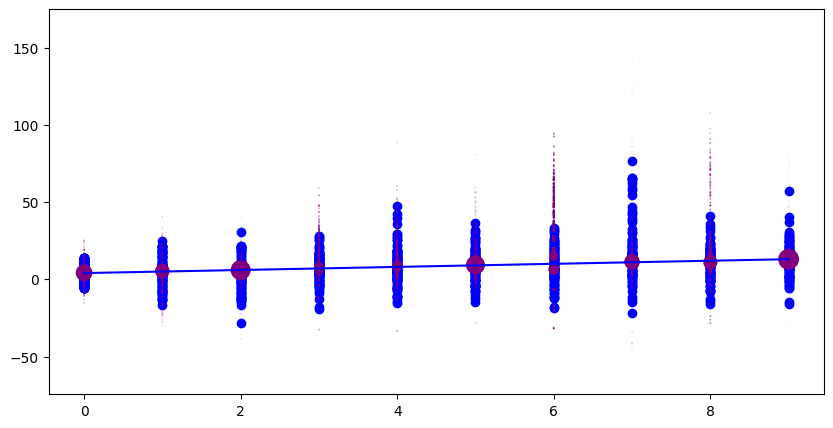

In [22]:
state_storage = []
state = [init_part_pf, init_weight_pf]
p = 10
for x_idx, x_val in enumerate(x_data_pf[:p]):
    meas_weights = rpf.observation(state[0], x_val)
    # meas_weights = pre_trans_weights[x_idx]
    state_storage.append(copy.deepcopy([state[0],meas_weights]))
    new_states, new_weights = rpf.resample_from_index(state[0], meas_weights)
    out_states = rpf.transition(new_states)
    state = [out_states, new_weights]

fig, ax = plt.subplots(1,1, figsize = (10,5))
x = np.array([0]*len(particle_states_inits[0]))
ax.scatter(x,init_part_pf[:,0], c = 'b')
for state_idx, state in enumerate(state_storage):
    p_pos = state[0][:,0] + (state[0][:,1] * params['time_step']) + (0.5 * state[0][:,2] * params['time_step']**2)
    ax.scatter(x + state_idx, state[0][:,0], c = 'b')
    ax.scatter(x + state_idx, p_pos, c = 'purple', s = state[1]*200)
ax.plot(x_data_pf[:p], c = 'b')
# ax.plot(np.insert(x_data_pf[:p],0,0), c = 'r')